In [23]:
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium import IFrame
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from branca.colormap import LinearColormap
import scienceplots as sp
from datetime import datetime, timedelta
plt.style.use('science')

In [24]:
us_airport_loc = pd.read_csv('udata/us_airport_loc.csv')
flow = pd.read_csv('udata/_map_data.csv')
merged_data = pd.merge(us_airport_loc, flow, left_on='Name', right_on='Code', how='left')
weather = np.load('udata/weather2016_2021.npy').T
u_mx = np.load('udata/udelay.npy')

arr = u_mx[:, :, 0].T
dep = u_mx[:, :, 1].T

print(arr.shape, dep.shape, weather.shape)

df_arr = pd.DataFrame(arr, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_dep = pd.DataFrame(dep, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_weather = pd.DataFrame(weather, index=range(
    78912), columns=us_airport_loc['Name'].tolist())

print(df_arr.shape, df_dep.shape, df_weather.shape)

data = np.load('udata/us_baseline_data.npz')
print(data.files)
length = 160

step = 0
x_ax = range(100)

print(data['true_47359'].shape)

data_ture = data['true_47359'][:, :, 0].T
data_STCGAT = data['STCGAT'][:, :, 1, step]  # -2
data_STPN = data['STPN'][:, :, step, 1]  # -1
data_GAT = data['GAT'][:, :, 0]
data_ASTGCN = data['ASTGCN'][:, :, 0]

print(data_ture.shape, data_STCGAT.shape, data_STPN.shape,
      data_GAT.shape, data_ASTGCN.shape)

df_true = pd.DataFrame(data_ture[step:step+100, :], index=x_ax, columns=us_airport_loc['Name'].tolist())
df_STCGAT = pd.DataFrame(data_STCGAT, index=range(160), columns=us_airport_loc['Name'].tolist())
df_STPN = pd.DataFrame(data_STPN,
                       index=range(160), columns=us_airport_loc['Name'].tolist())
df_GAT = pd.DataFrame(data_GAT[step:step+100, :],
                      index=x_ax, columns=us_airport_loc['Name'].tolist())
df_ASTGCN = pd.DataFrame(data_ASTGCN[step:step+100, :], index=x_ax, columns=us_airport_loc['Name'].tolist())

(78912, 70) (78912, 70) (78912, 70)
(78912, 70) (78912, 70) (78912, 70)
['true_47359', 'STCGAT', 'STPN', 'GAT', 'ASTGCN']
(70, 160, 2)
(160, 70) (160, 70) (160, 70) (160, 70) (160, 70)


In [25]:
def get_delay_time(time_slot, airport_code):
    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)
    weather = df_weather.loc[time_slot, :].fillna(0)

    arr = arr_delay[airport_code]
    dep = dep_delay[airport_code]
    weather_data = weather[airport_code]
    if weather_data > 0:
        weather_data = 1
    else:
        weather_data = 0

    return arr, dep, weather_data


def get_delay_time_all(airport_code):
    arr_delay = df_arr.loc[:, :]
    dep_delay = df_dep.loc[:, :]

    arr = arr_delay[airport_code]
    dep = dep_delay[airport_code]

    return arr, dep


def slot_to_time(slot):
    # Calculate the number of days and the slot within that day.
    days_passed = slot // 36
    slot_in_day = slot % 36

    # Calculate the hour and minute based on the slot_in_day.
    hour = 6 + slot_in_day // 2
    minute = (slot_in_day % 2) * 30

    # Add the days_passed to the starting date (2016-01-01).
    date = datetime(2016, 1, 1) + timedelta(days=days_passed)
    date_str = date.strftime('%Y-%m-%d')

    return f"{date_str} {hour:02d}:{minute:02d}"


def get_airport_location(airport_code):
    airport = us_airport_loc[us_airport_loc['Name'] == airport_code]
    if airport.empty:
        print(f"No location data found for airport {airport_code}")
        return None
    else:
        lat = airport['LATITUDE'].values[0]
        lon = airport['LONGITUDE'].values[0]
        return lat, lon


def plot_map(ax, time_slot, delay_type='dep'):
    map = Basemap(width=11000000, height=5500000,
                  rsphere=(6378137.00, 6356752.3142),
                  resolution='l', area_thresh=1000., projection='lcc',
                  lat_1=45., lat_2=55, lat_0=45, lon_0=-110., ax=ax)
    map.drawcoastlines(linewidth=0.5)
    map.drawstates(linewidth=0.5)
    map.drawcountries(linewidth=1.5)
    map.fillcontinents(color='lightgray')
    # map.fillcontinents(color='lightgray', lake_color='lightblue')
    # map.drawmapboundary(fill_color='lightblue')
    plot_airports(ax, map, s=40, time_slot=time_slot, delay_type=delay_type)
    return map


def plot_airports(ax, map, s, time_slot, delay_type, dep=None, arr=None):
    time_slot = time_slot

    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)

    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(-10, 30)

    for airport in us_airport_loc['Name']:
        lat, lon = get_airport_location(airport)
        x, y = map(lon, lat)
        arr = arr_delay[airport]
        dep = dep_delay[airport]

        if delay_type == 'arr':
            size = s * norm(arr)
            color = cmap(norm(arr))
            data = arr
        elif delay_type == 'dep':
            size = s * norm(dep)
            color = cmap(norm(dep))
            data = dep

        size = max(0, size)
        res = []
        if data > 10:
            res.append([airport, data])
            # ax.text(x, y, airport, fontsize=15, color='black', ha='center', va='center')

        map.scatter(x, y, s=size*size+100, color=color, marker='o', alpha=0.8)

        # for i in res:
        # print("Time Slot: %d, Airport: %s, Delay: %f, Type: %s" %
        #       (time_slot, airport, data, delay_type))


def plot_arr_and_dep(airport_code):
    arr, dep = get_delay_time_all(airport_code)
    time_points = list(range(len(arr)))

    # Create a figure and axis object
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 12))
    fig.text(0.5, 0.04, airport_code, ha='center', fontsize=30)

    # Plot the arrival delay time
    ax1.plot(arr, label='Arrival Delay')

    # Set the title and axis labels for the first plot
    ax1.set_title('Arrival Delay Time', fontsize=20)
    ax1.set_xlabel('Time Slot', fontsize=20)
    ax1.set_ylabel('Delay Time (min)', fontsize=20)

    # Set the minimum value of y-axis to 0
    ax1.set_ylim(bottom=-10)

    # Add a legend to the first plot
    ax1.legend(fontsize=20)

    # Add a horizontal line at y=0 in the first plot
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Plot the departure delay time
    ax2.plot(dep, label='Departure Delay', color='g')

    # Set the title and axis labels for the second plot
    ax2.set_title('Departure Delay Time', fontsize=20)
    ax2.set_xlabel('Time Slot', fontsize=20)
    ax2.set_ylabel('Delay Time (min)', fontsize=20)

    # Set the minimum value of y-axis to 0
    ax2.set_ylim(bottom=-10)

    # Add a legend to the second plot
    ax2.legend(fontsize=20)

    # Add a horizontal line at y=0 in the second plot
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Show the plot
    ax1.set_xlim([0, 300])
    ax2.set_xlim([0, 300])

    arr.to_csv('udata/us_arr_'+airport_code+'.csv', index=False)
    dep.to_csv('udata/us_dep_'+airport_code+'.csv', index=False)
    plt.show()


def plot_map_us(timeslot, label=None):
    arr = u_mx[:, :, 0].T
    # name = "Airport Departure Delays for {}".format(slot_to_time(timeslot))
    # name = f'Departure Delay {label} ({step+1} steps prediction)'
    # Replace NaN values with 0 for no delay
    idx = 47359
    if label == 'FAST-CA':
        df_dep_time_slot = df_STCGAT.iloc[timeslot].fillna(0)
    elif label == 'STPN':
        df_dep_time_slot = df_STPN.iloc[timeslot].fillna(0)
    elif label == 'GAT':
        df_dep_time_slot = df_GAT.iloc[timeslot].fillna(0)
    elif label == 'ASTGCN':
        name = 'Departure Delay '+label+' '+slot_to_time(idx+step+timeslot)
        df_dep_time_slot = df_ASTGCN.iloc[timeslot].fillna(0)
    elif label == 'Truth':
        name = 'Departure Delay '+label+' '+slot_to_time(idx+step+timeslot)
        df_dep_time_slot = df_true.iloc[timeslot].fillna(0)

    # Merge the delay data with the airport location data
    airport_delay_data = merged_data.copy()
    airport_delay_data['Delay'] = df_dep_time_slot.values
    airport_delay_data['Size'] = (airport_delay_data['Passengers'] -
                                  airport_delay_data['Passengers'].min()) / airport_delay_data['Passengers'].max() * 20
    airport_delay_data['Size'] = airport_delay_data['Size'].clip(upper=20)
    airport_delay_data['Size'] = airport_delay_data['Size'].clip(lower=5)

    # Use the Jet color scale and set the range from -10 to 30
    color_scale = px.colors.diverging.Picnic

    fig = px.scatter_geo(airport_delay_data,
                         lat='LATITUDE',
                         lon='LONGITUDE',
                         color='Delay',
                         hover_name='AIRPORT',
                         size='Size',  # Use the absolute value for size
                         color_continuous_scale='Jet',  # Use the Jet color scale
                         # Set color scale range from -10 to 30
                         range_color=[-20, 30],
                         scope='usa',
                         labels={'Delay': 'Departure Delay (minutes)'},
                         size_max=25,
                         )

    fig.update_geos(
        landcolor='white',  # Set land color to white
        lakecolor='white',  # Set lake color to white (if desired)
        showland=True,
        showlakes=True,
        showcountries=True,  # Show country borders
        countrycolor='black',  # Set country border color to black
        countrywidth=1.0,  # Set country border width
        subunitcolor='black'  # Set state borders color to black
    )

    fig.update_traces(marker=dict(line=dict(width=1, color='black')))

    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        plot_bgcolor='white',  # Set the plot background to white
        paper_bgcolor='white',  # Set the paper background to white
        font=dict(family="Times New Roman", size=12,
                  color="black"),  # Set font
        coloraxis_colorbar=dict(
            title='Departure Delay (min)',
            title_text='Departure Delay (minutes)',  # Set the title text
            title_font=dict(size=18, family="Times New Roman",
                            color="black"),  # Set the title font
            titleside='right',
            len=0.8,  # Length of the color bar (75% of the plot height)
            x=0.93,  # Position the color bar to the far right of the plot
            y=0.47,  # Position the color bar in the middle vertically
            thickness=15,  # Width of the color bar
            tickangle=-90  # Rotate the ticks to vertical
        ),
        title={
            'text': name,
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 24}
        }
    )

    # Show the plot
    # fig.show()
    file_name = "output_map_us/us_"+name+".png"

    file_name = "output_map_us/us_"+label+"_"+str(timeslot)+".png"
    fig.write_image(file_name,
                    width=1000, height=600, scale=2)

In [36]:
def plot_arr_and_dep(airport_code):
    arr, dep = get_delay_time_all(airport_code)
    time_points = list(range(len(arr)))

    # Create a figure and axis object
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 12))
    fig.text(0.5, 0.04, airport_code, ha='center', fontsize=20)

    # Plot the arrival delay time
    ax1.plot(arr, label='Arrival Delay')

    # Set the title and axis labels for the first plot
    ax1.set_title('Arrival Delay Time', fontsize=20)
    ax1.set_xlabel('Time Slot (30 min)', fontsize=10)
    ax1.set_ylabel('Delay Time (min)', fontsize=20)

    # Set the minimum value of y-axis to 0
    ax1.set_ylim(bottom=-10)

    # Add a legend to the first plot
    ax1.legend(loc='upper left', fontsize=20)

    # Add a horizontal line at y=0 in the first plot
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Plot the departure delay time
    ax2.plot(dep, label='Departure Delay', color='g')

    # Set the title and axis labels for the second plot
    ax2.set_title('Departure Delay Time', fontsize=20)
    ax2.set_xlabel('Time Slot (30 min)', fontsize=10)
    ax2.set_ylabel('Delay Time (min)', fontsize=20)

    # Set the minimum value of y-axis to 0
    ax2.set_ylim(bottom=-10)

    # Add a legend to the second plot
    ax2.legend(loc='upper left', fontsize=20)

    # Add a horizontal line at y=0 in the second plot
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Show the plot
    ax1.set_xlim([0, 300])
    ax2.set_xlim([0, 300])

    arr.to_csv('udata/us_arr_'+airport_code+'.csv', index=False)
    dep.to_csv('udata/us_dep_'+airport_code+'.csv', index=False)
    plt.show()

GIF


In [37]:
# import imageio
# for i in range(0, 100):
#     plot_map_us(i, 'Truth')
#     plot_map_us(i, 'ASTGCN')

# label = 'ASTGCN'
# with imageio.get_writer(uri=f'{label}.gif', mode='I', fps=5, loop=0) as writer:
#     for i in range(100):
#         file_name = "output_map_us/us_"+label+"_"+str(i)+".png"
#         writer.append_data(imageio.imread(file_name))

# label = 'Truth'
# with imageio.get_writer(uri=f'{label}.gif', mode='I', fps=5, loop=0) as writer:
#     for i in range(100):
#         file_name = "output_map_us/us_"+label+"_"+str(i)+".png"
#         writer.append_data(imageio.imread(file_name))

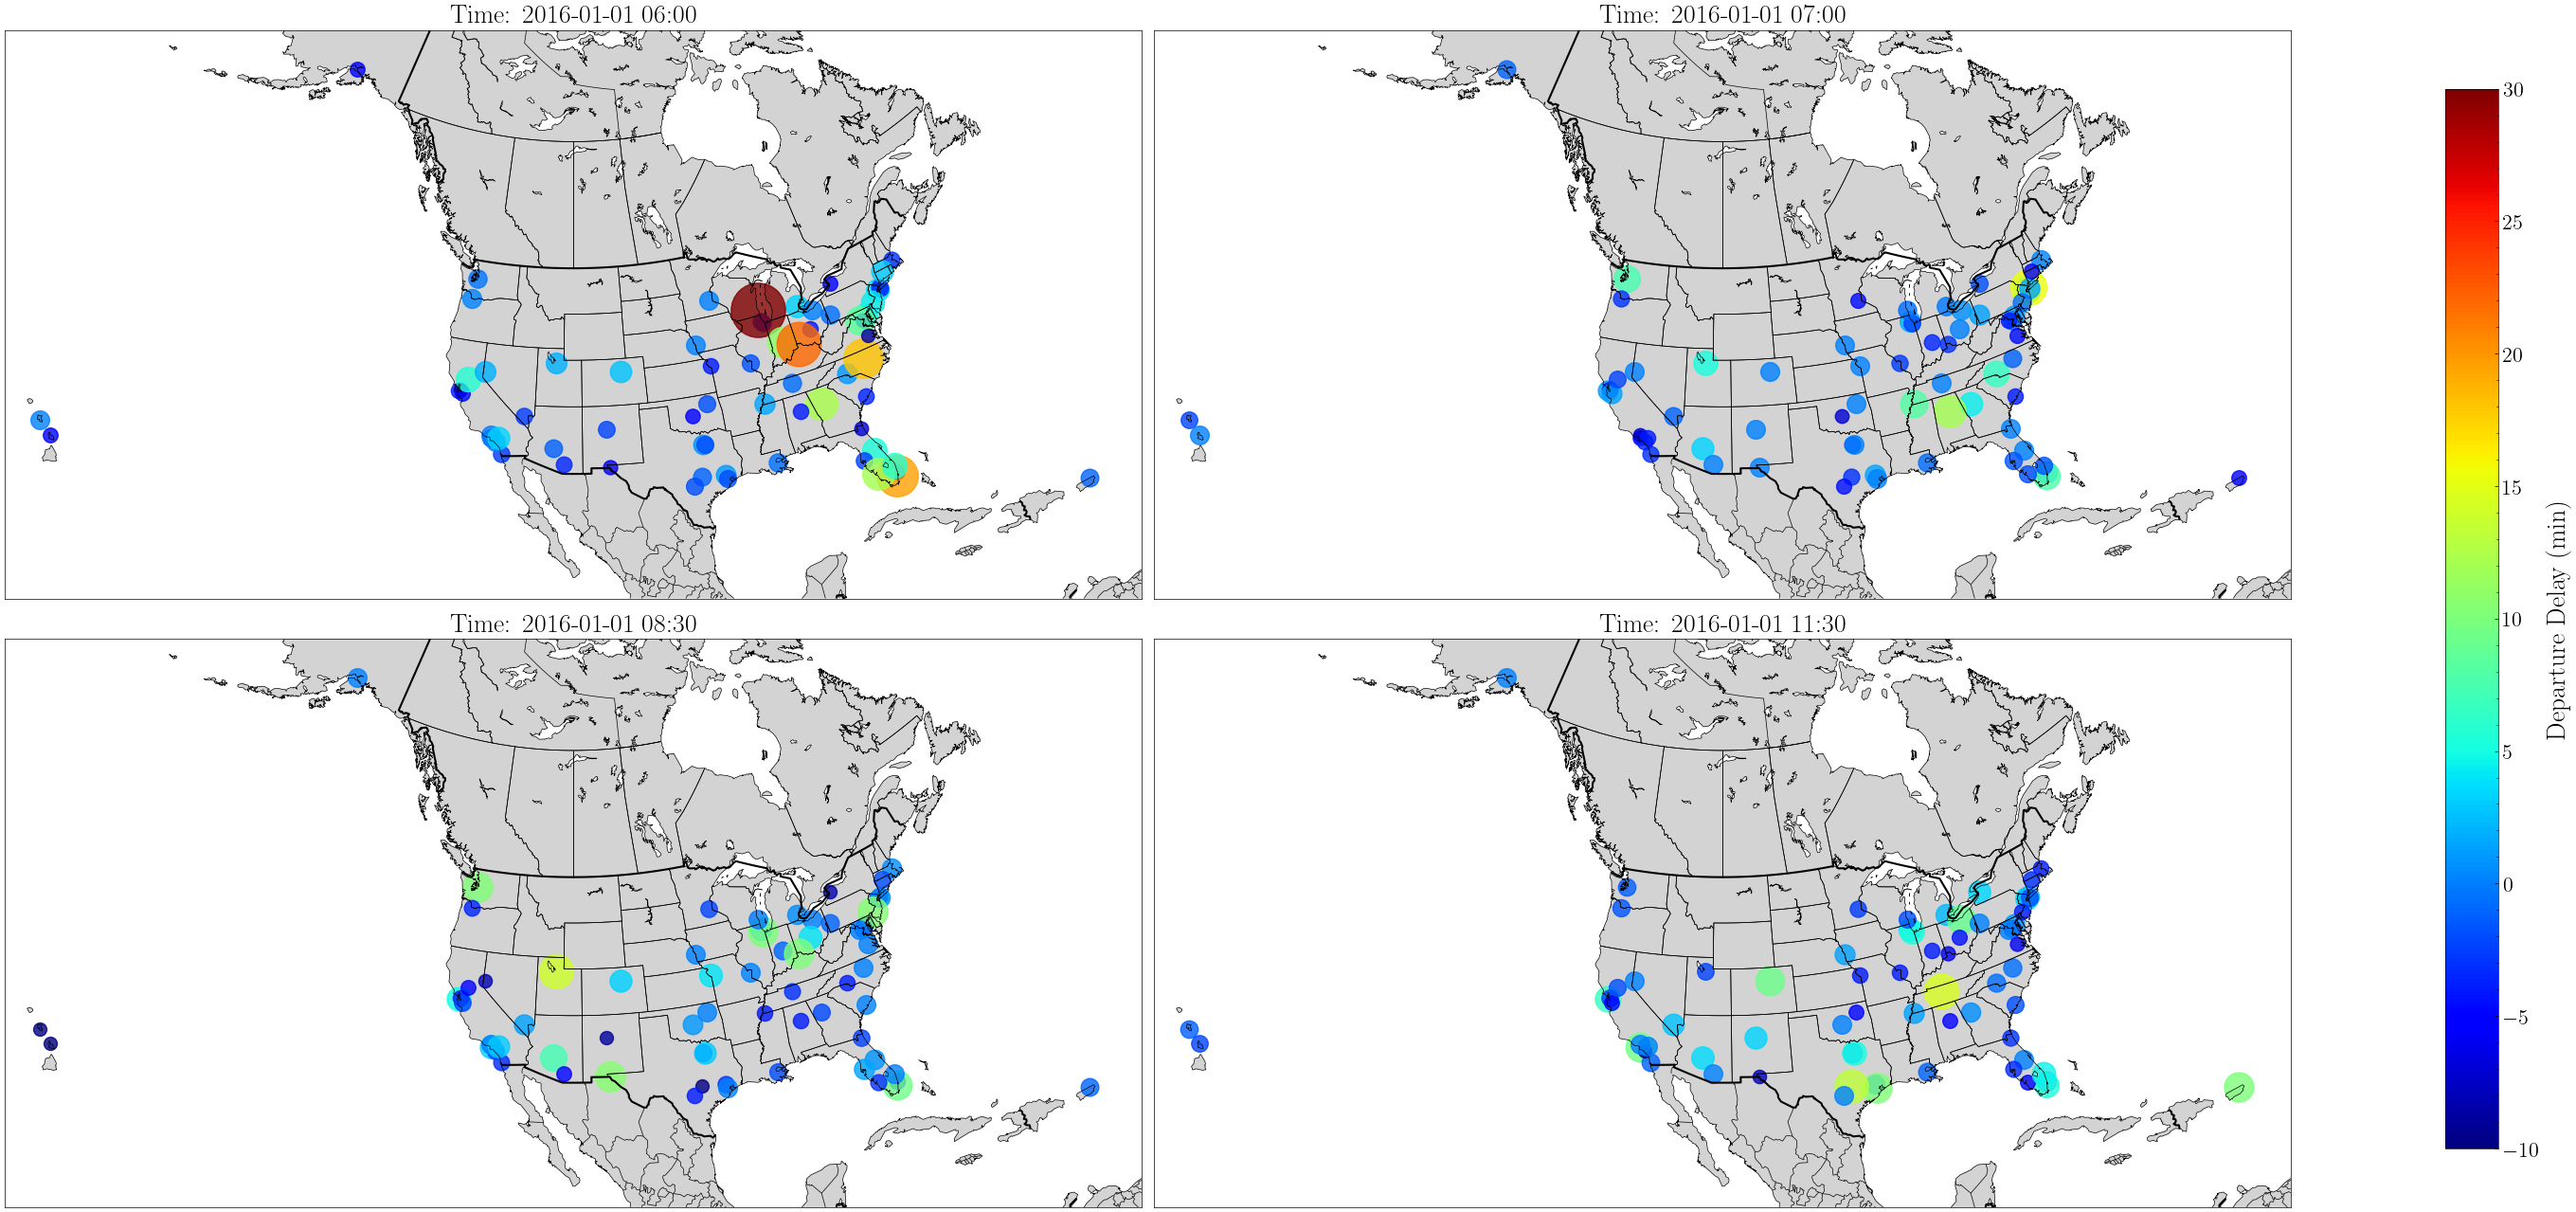

In [38]:
# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(33, 13))

# Plot each map in a subplot
time = [0, 2, 5, 11]
plot_map(axes[0, 0], 0, 'dep')
plot_map(axes[0, 1], 2, 'dep')
plot_map(axes[1, 0], 5, 'dep')
plot_map(axes[1, 1], 11, 'dep')

axes[0, 0].set_title('Time: ' + slot_to_time(0), fontsize=20)
axes[0, 1].set_title('Time: ' + slot_to_time(2), fontsize=20)
axes[1, 0].set_title('Time: ' + slot_to_time(5), fontsize=20)
axes[1, 1].set_title('Time: ' + slot_to_time(11), fontsize=20)

plt.tight_layout()

norm = plt.Normalize(-10, 30)
cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Departure Delay (min)', shrink=0.9, ax=axes)
cbar.set_label('Departure Delay (min)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()
# for t in time:
#     print(slot_to_time(t))

In [39]:
airport_name = pd.read_csv("udata/USA.csv")

# Create a dictionary to store the number of missing values for each airport
missing_values = {}
avg_arr_delay = {}
avg_dep_delay = {}


# Loop through each airport and calculate the number of missing values
for index, row in airport_name.iterrows():
    airport = row.loc['Name']
    arr_delay, dep_delay = get_delay_time_all(airport)
    num_missing = arr_delay[:150].isna().sum() + dep_delay.isna().sum()
    missing_values[airport] = num_missing
    avg_arr_delay[airport] = arr_delay[:300].mean()
    avg_dep_delay[airport] = dep_delay[:300].mean()

# Sort the airports by the number of missing values
sorted_airports = sorted(missing_values.items(),
                         key=lambda x: x[1], reverse=True)
sorted_avg_arr_delay = sorted(
    avg_arr_delay.items(), key=lambda x: x[1], reverse=True)
sorted_avg_dep_delay = sorted(
    avg_dep_delay.items(), key=lambda x: x[1], reverse=True)

In [46]:
print("Top 10 airports with the most missing values:")
for airport, num_missing in sorted_airports[:10]:
    print(f"{airport}: {num_missing}")

Top 10 airports with the most missing values:
ELP: 35950
BHM: 34508
TUS: 34462
TUL: 32777
RIC: 31017
ANC: 29619
MEM: 29166
BUF: 28725
CHS: 27953
OKC: 27507


In [41]:
print("Top 10 airports with the most average arrival delay valuse:")
for airport, arr in sorted_avg_arr_delay[:10]:
    print(f"{airport}: {arr}")

Top 10 airports with the most average arrival delay valuse:
OAK: 6.141437674233373
PDX: 4.319071930484974
RNO: 4.03015873015873
SEA: 3.849062092061993
LAS: 3.2867399733765836
LAX: 3.1033790743097014
SFO: 3.0663983669043695
SMF: 2.495823268921095
BUR: 2.121540880503145
DAL: 1.6760447588126162


In [42]:
print("Top 10 airports with the most average departure delay valuse:")
for airport, dep in sorted_avg_dep_delay[:10]:
    print(f"{airport}: {dep}")

Top 10 airports with the most average departure delay valuse:
OAK: 8.327978955351217
LAX: 8.314757029010226
LAS: 8.100150547551863
MIA: 8.083196553706822
DAL: 7.511400243872568
SFO: 7.4499250780360855
SMF: 6.6915266106442575
PBI: 6.60226106045255
FLL: 6.219209478499039
SJU: 6.188569531398216


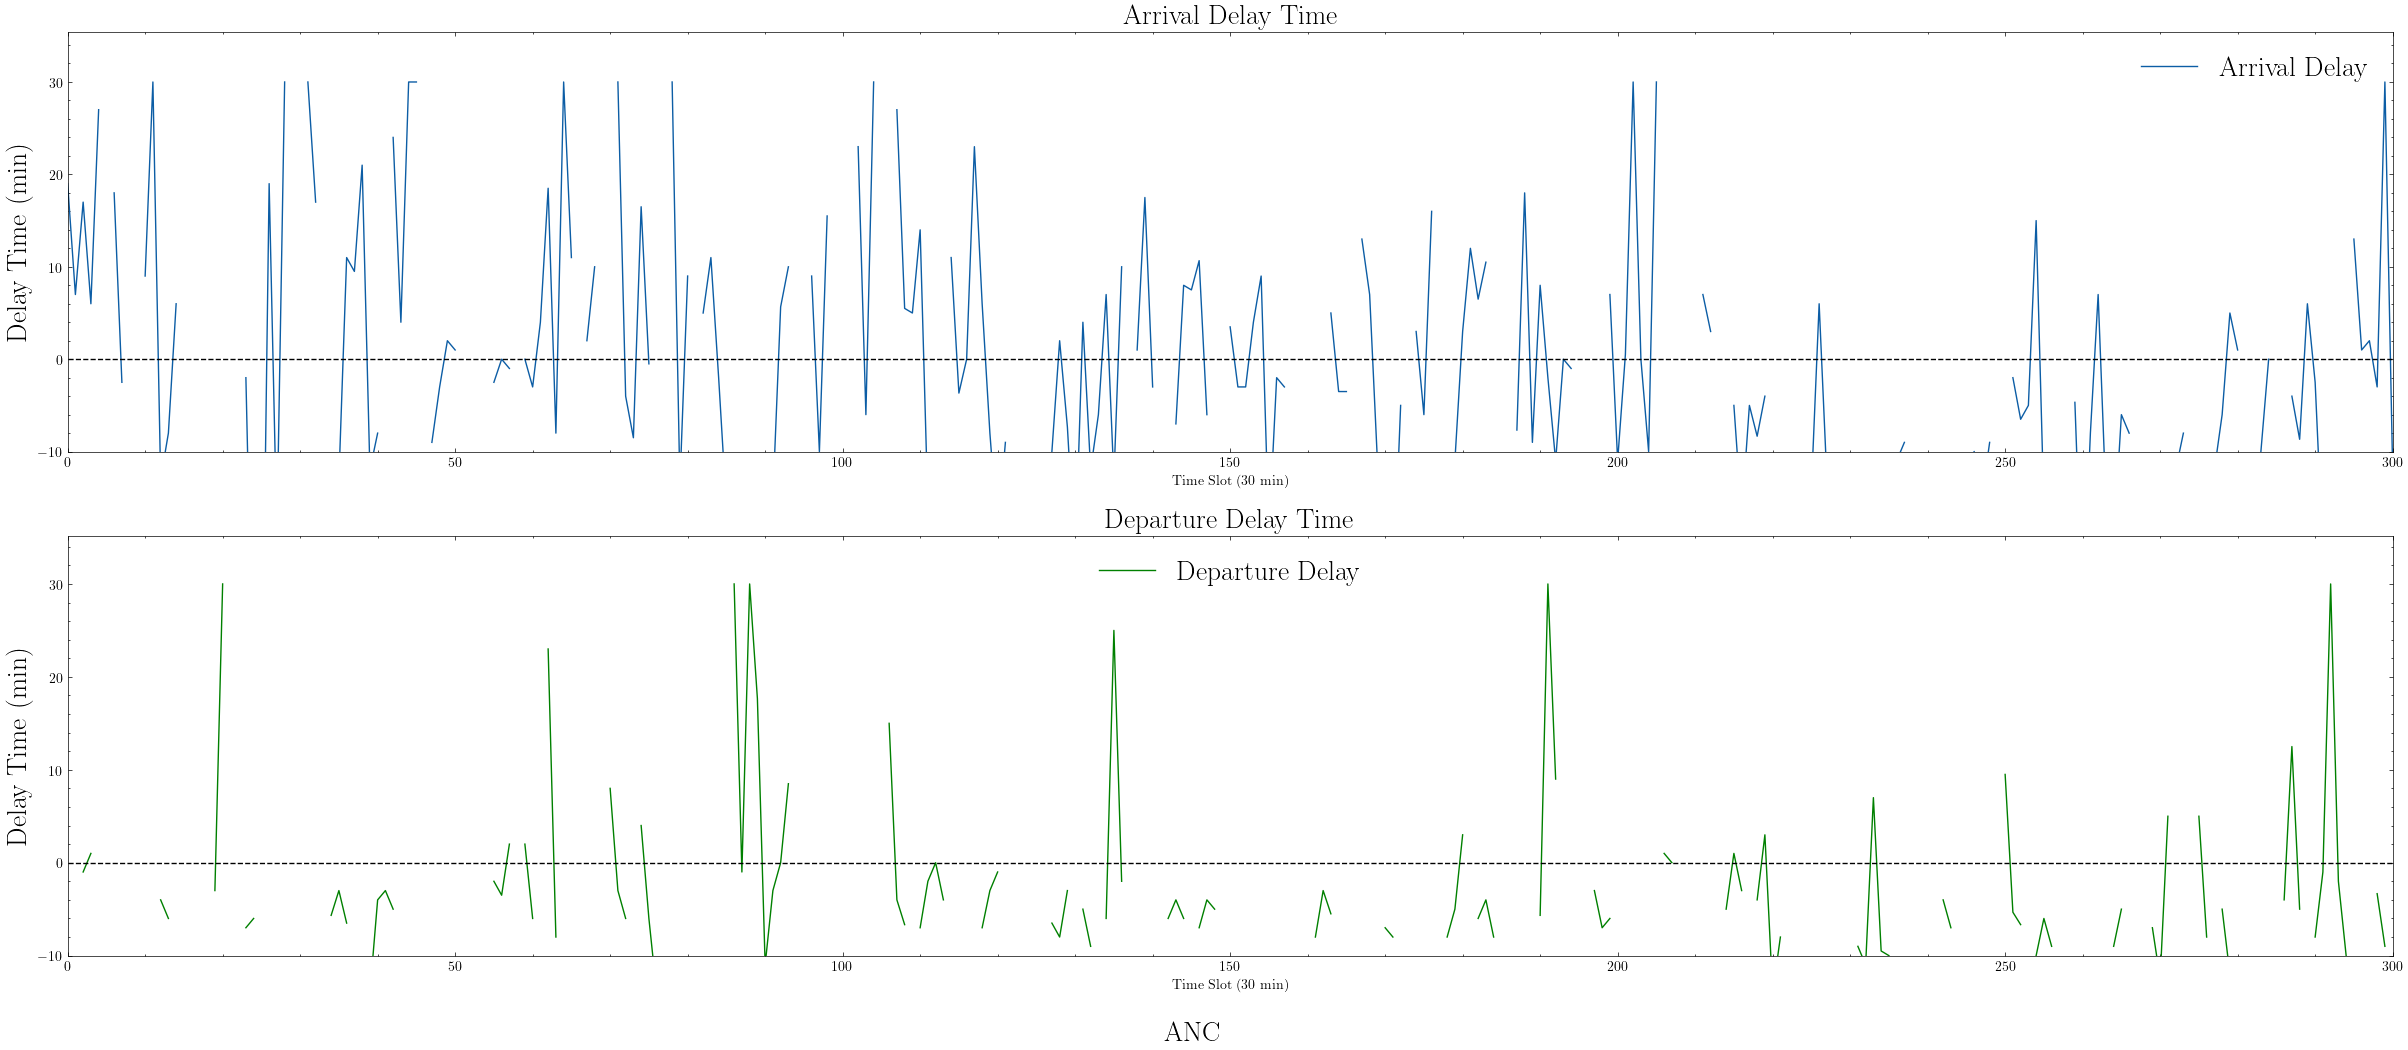

In [52]:
plot_arr_and_dep('ANC')

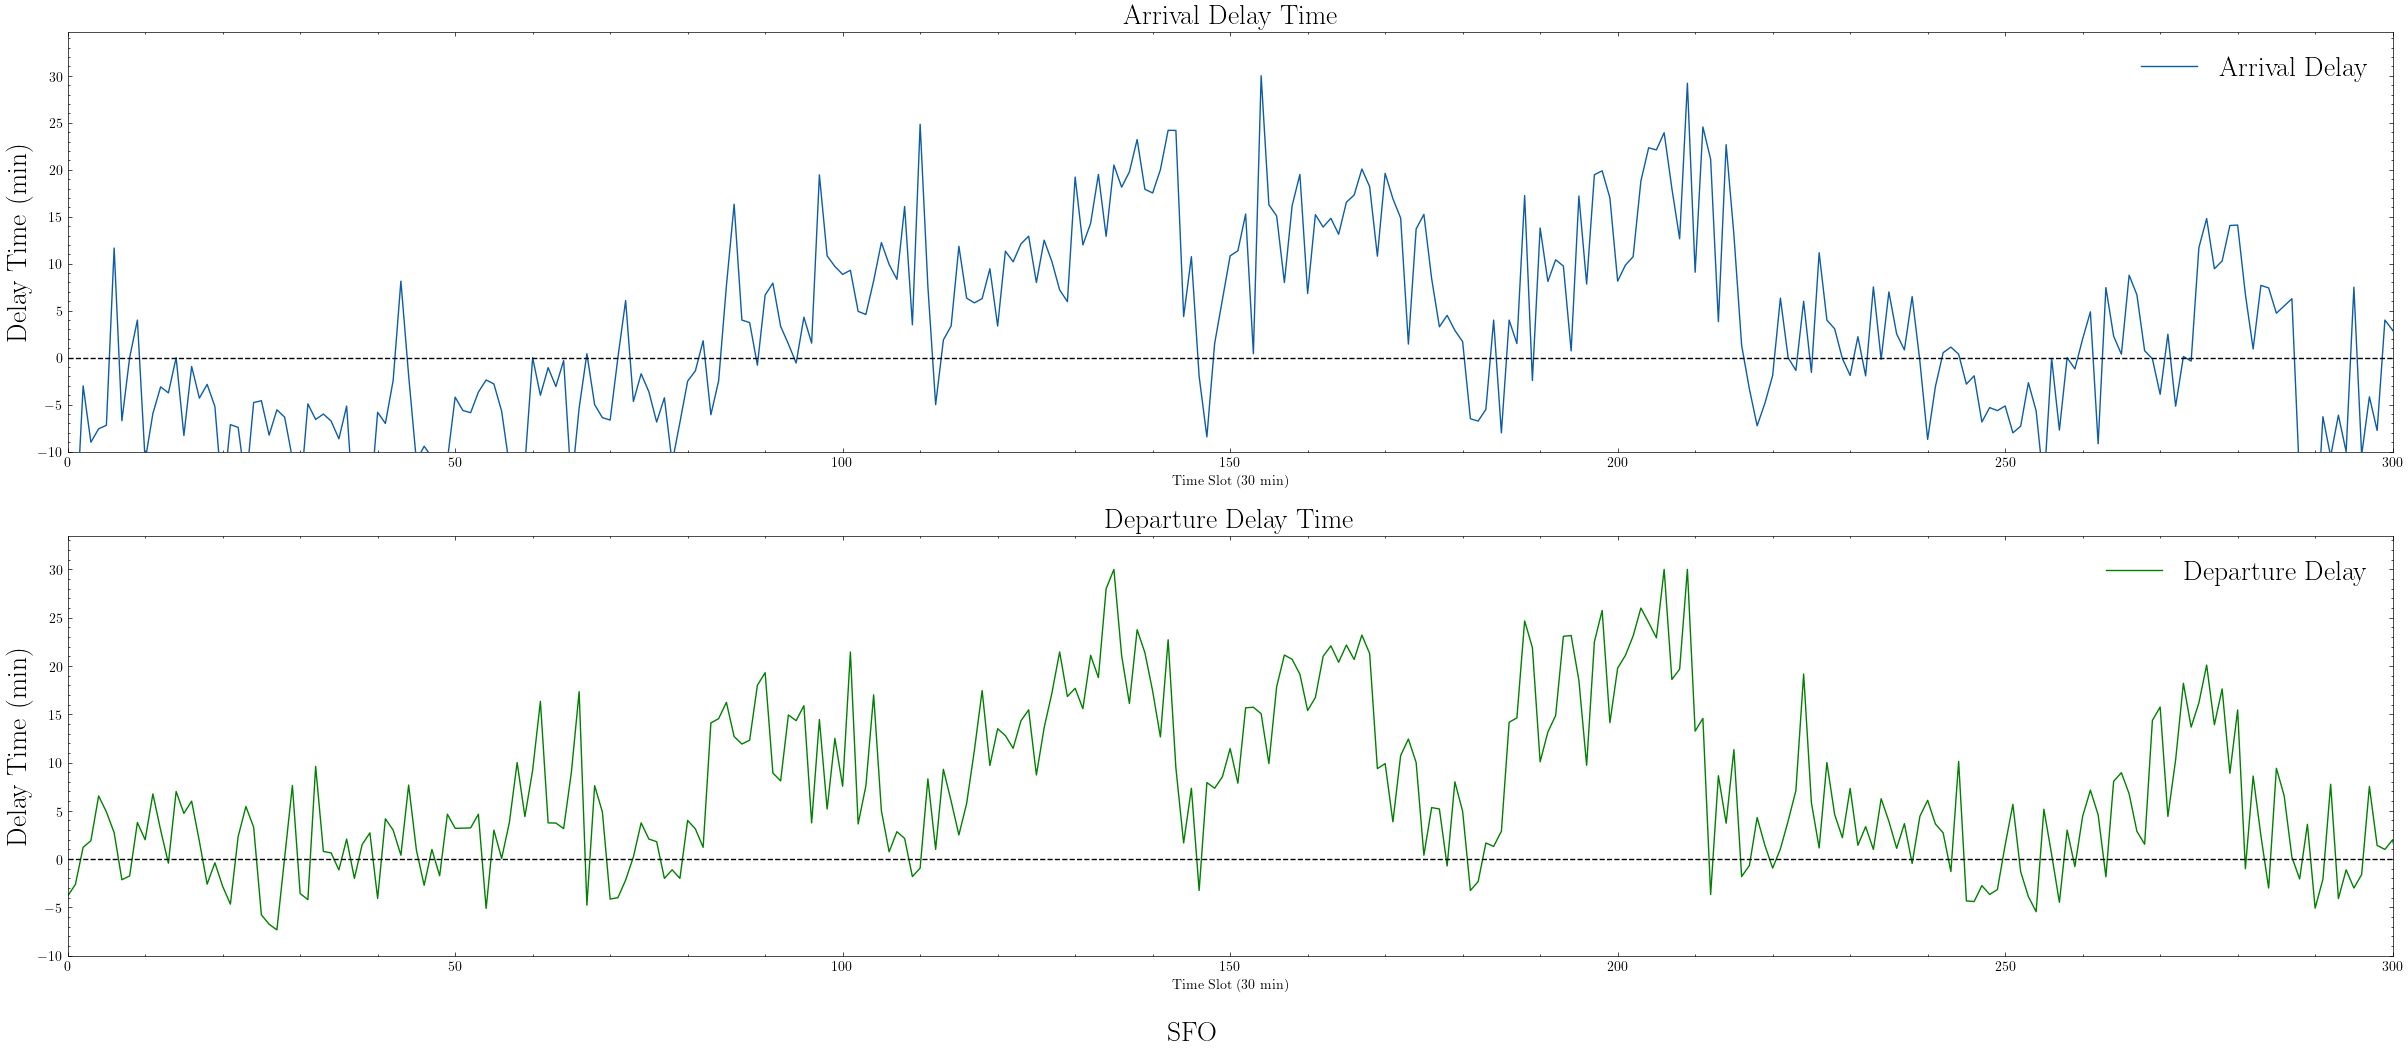

In [50]:
plot_arr_and_dep('SFO')
# [idx, 0, :]

/var/folders/q8/h2vz6sj57rj02qh11jbnrysh0000gn/T/ipykernel_3909/3604915649.py:6: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



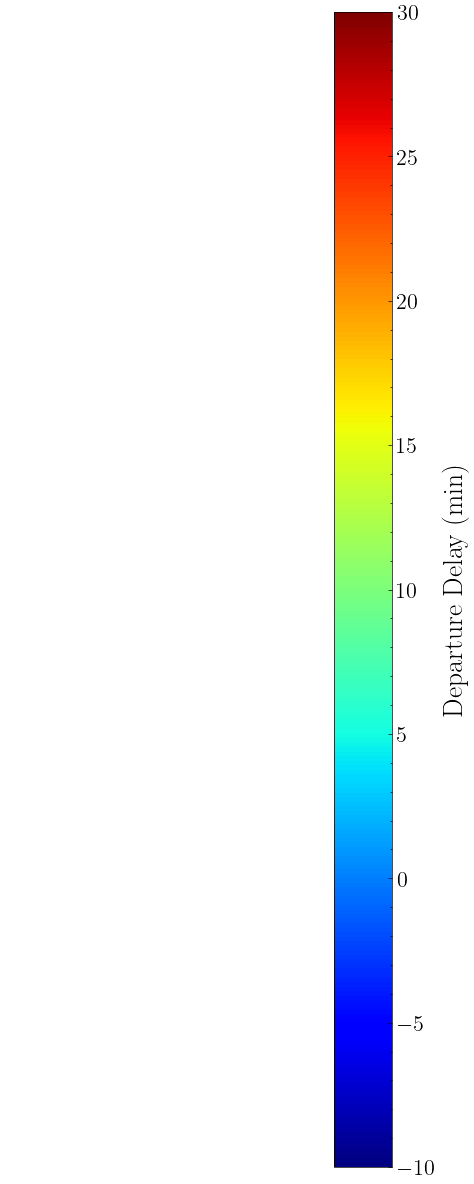

In [51]:
plt.figure(figsize=(5, 15))
norm = plt.Normalize(-10, 30)
cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Departure Delay (min)', fontsize=20, fontweight='bold')
cbar.ax.tick_params(labelsize=16)
plt.axis('off')
plt.show()